## Process Optimization - the `Main` code 

### Fourth Batch of Bayesian Optimization based on Experimental Data produced on Nov 8, 2020
- This notebook is to run Bayesian Optimization on initial sampling data, and provide the first batch suggestion on experiment conditions
- Experiments of perovskite devices are prepared by Nick Rolston and Thomas Colburn (Stanfrod University) 
- Jupyter Notebook is prepared by Zhe Liu (Massachusetts Insititute of Technology)

In [1]:
import numpy as np
import pandas as pd
import emukit
import GPy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_all_device  = pd.read_excel("../Experimental Data/All_device_data_processed_20210126.xlsx", sheet_name= "Sheet1")
print(df_all_device.columns)
df_all_device = df_all_device.iloc[:,2:13]
df_all_device = df_all_device.dropna()
df_all_device.columns = ['Temperature [\N{DEGREE SIGN}C]', 'Speed [mm/s]',
       'Spray Flow [uL/min]', 'Plamsa Height [cm]', 'Plasma Gas Flow [L/min]', 'Plasma DC [%]',
        'Jsc [mA/cm2]', 'Voc [V]', 'FF [-]', 'Efficiency [%]','Film Quality?']
df_all_device

Index(['ML Condition', 'Sample', 'Temperature [°C]', 'Speed [mm/s]',
       'Spray Flow [uL/min]', 'Plamsa Height [cm]', 'Plasma Gas Flow [L/min]',
       'Plasma DC [%]', 'Jsc [mA/cm2]', 'Voc [V]', 'FF [-]', 'Efficiency [%]',
       'Film Success or not?', 'Unnamed: 13', ' ', 'Unnamed: 15',
       'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19',
       'Unnamed: 20', 'Unnamed: 21'],
      dtype='object')


,Temperature [°C],Speed [mm/s],Spray Flow [uL/min],Plamsa Height [cm],Plasma Gas Flow [L/min],Plasma DC [%],Jsc [mA/cm2],Voc [V],FF [-],Efficiency [%],Film Quality?
0,155,200,5000,1.2,35,50,16.261900,0.932514,0.39,5.914137,Yes
1,160,225,3000,0.8,30,75,2.239204,0.108900,0.25,0.060982,No
2,135,200,2500,1.0,25,75,23.176100,0.926920,0.60,12.889485,Yes
3,150,175,2000,1.0,20,100,20.804760,0.739500,0.31,4.769839,No
4,170,275,4500,1.2,16,50,21.509520,0.832600,0.66,11.820590,No
...,...,...,...,...,...,...,...,...,...,...,...
139,170,300,2500,1.0,25,100,15.171420,0.721700,0.39,4.270196,No
140,160,100,4000,1.0,25,75,15.428570,0.951900,0.49,7.196364,Yes
141,155,275,2500,1.2,35,100,5.652380,0.643600,0.43,1.564446,Yes
142,140,225,3000,1.0,20,50,21.495230,0.917800,0.72,14.204410,Yes


In [42]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

X=df_all_device.iloc[:,:6]
y=df_all_device['Efficiency [%]']

X=X.to_numpy(dtype='float')
y=y.to_numpy(dtype='float').reshape(-1,1)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

scaler = StandardScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X = scaler.transform(X)

scaler_y = StandardScaler()
scaler_y.fit(y)
y_train = scaler_y.transform(y_train)
y_test = scaler_y.transform(y_test)
y = scaler_y.transform(y)

In [5]:
#print(gb_random.best_params_)
best_params = {'subsample': 0.95, 
               'n_estimators': 105, 
               'min_samples_split': 2, 
               'min_samples_leaf': 2, 
               'max_features': 'sqrt',
               'max_depth': 4, 
               'learning_rate': 0.075,
               'alpha':0.99
               }

In [6]:
from sklearn.ensemble import GradientBoostingRegressor
GBregressor_list = []
y_pred_list = []
y_train_pred_list = []
y_test_pred_list = []
for i in np.arange(100):
    GBregressor = GradientBoostingRegressor()
    GBregressor.set_params(**best_params)
    GBregressor.fit(X_train, y_train.ravel())
    #GBregressor.fit(X, y.ravel())

    GBregressor_list.append(GBregressor)
    
    y_train_pred=scaler_y.inverse_transform(GBregressor_list[i].predict(X_train).reshape(-1,1))
    y_test_pred=scaler_y.inverse_transform(GBregressor_list[i].predict(X_test).reshape(-1,1))
    y_pred=scaler_y.inverse_transform(GBregressor_list[i].predict(X).reshape(-1,1))
    y_train_pred_list.append(y_train_pred)
    y_test_pred_list.append(y_test_pred)
    y_pred_list.append(y_pred)
y_pred_mean = np.mean(y_pred_list, axis = 0)
y_train_pred_mean = np.mean(y_train_pred_list, axis = 0)
y_test_pred_mean = np.mean(y_test_pred_list, axis = 0)


train rmse: 1.0009
test rmse: 1.1523
all rmse: 1.0334
train R^2: 0.9507
test R^2: 0.8997
all R^2: 0.9434
train spearman: 0.9438
test spearman: 0.8335
all spearman: 0.9314


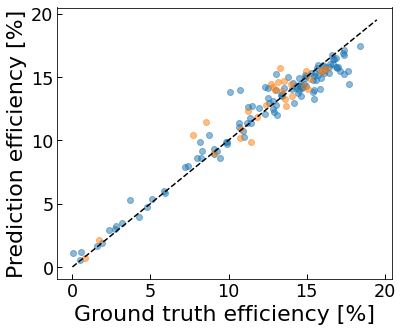

In [7]:
y_train_pred = y_train_pred_mean
y_test_pred = y_test_pred_mean
y_pred = y_pred_mean

from sklearn.metrics import mean_squared_error
mse = mean_squared_error
mse_train = mse(y_train_pred,scaler_y.inverse_transform(y_train))
mse_test = mse(y_test_pred,scaler_y.inverse_transform(y_test))
mse_all = mse(y_pred,scaler_y.inverse_transform(y))
print ('train rmse: %.4f' % (np.sqrt(mse_train)))
print ('test rmse: %.4f' % (np.sqrt(mse_test)))
print ('all rmse: %.4f' % (np.sqrt(mse_all)))


rsquared_train = r2_score(scaler_y.inverse_transform(y_train),y_train_pred)
rsquared_test = r2_score(scaler_y.inverse_transform(y_test), y_test_pred)
rsquared_all = r2_score(scaler_y.inverse_transform(y), y_pred)
print ('train R^2: %.4f' % (rsquared_train))
print ('test R^2: %.4f' % (rsquared_test))
print ('all R^2: %.4f' % (rsquared_all))

sprman_train = spearmanr(y_train_pred,scaler_y.inverse_transform(y_train))
sprman_test = spearmanr(y_test_pred,scaler_y.inverse_transform(y_test))
sprman_all = spearmanr(y_pred,scaler_y.inverse_transform(y))
print ('train spearman: %.4f' % (sprman_train[0]))
print ('test spearman: %.4f' % (sprman_test[0]))
print ('all spearman: %.4f' % (sprman_all[0]))

fs = 22
plt.figure(figsize=(6, 5))
plt.scatter(scaler_y.inverse_transform(y_train),y_train_pred, alpha =0.5)
plt.scatter(scaler_y.inverse_transform(y_test),y_test_pred, alpha =0.5)
#plt.scatter(y_scaled,y_pred, alpha =0.5)
yref = np.arange(0, 20, 0.5)
plt.plot(yref, yref, '--',color='black')
plt.xlabel('Ground truth efficiency [%]', fontsize = fs)
plt.ylabel('Prediction efficiency [%]', fontsize = fs)
plt.xticks([0, 5, 10, 15, 20])
#plt.title("Gradient Boosting")
plt.tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
#plt.savefig("Pervoskite Opt for Scale-up/Prelim_data_analysis/data_plots/RFR"+str(X1.name[:4])+".png",dpi=300)
plt.show()

In [8]:
Xc = df_all_device.iloc[:,:6]
yc = []
for i in np.array(df_all_device.iloc[:,-1].values):
    if i == 'Yes':
        yc.append(1)
    elif i == 'No':
        yc.append(0)

Xc=Xc.to_numpy(dtype='float')
yc=np.array(yc).reshape(-1,1)

Xc_train,Xc_test,yc_train,yc_test=train_test_split(Xc,yc,test_size=0.2)

scaler_Xc = StandardScaler()
scaler_Xc.fit(Xc)
Xc_train = scaler.transform(Xc_train)
Xc_test = scaler.transform(Xc_test)
Xc = scaler.transform(Xc)

In [9]:
best_params_ = {'subsample': 0.90, 
               'n_estimators': 70, 
               'min_samples_split': 2, 
               'min_samples_leaf': 1, 
               'max_features': 'sqrt',
               'max_depth': 4, 
               'learning_rate': 0.125,
               #'alpha':0.0001
               }

In [10]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
GBclassifier_Cons_list = []
yc_pred_list = []
yc_train_pred_list = []
yc_test_pred_list = []
for i in np.arange(100):
    GBclassifier_Cons = GradientBoostingClassifier()
    GBclassifier_Cons.set_params(**best_params_)
    GBclassifier_Cons.fit(Xc_train, yc_train.ravel())
    GBclassifier_Cons.fit(Xc, yc.ravel())
    GBclassifier_Cons_list.append(GBclassifier_Cons)
    
    yc_train_pred=GBclassifier_Cons_list[i].predict_proba(Xc_train)[:,1]
    yc_test_pred=GBclassifier_Cons_list[i].predict_proba(Xc_test)[:,1]
    yc_pred=GBclassifier_Cons_list[i].predict_proba(Xc)[:,1]
    yc_train_pred_list.append(yc_train_pred)
    yc_test_pred_list.append(yc_test_pred)
    yc_pred_list.append(yc_pred)
yc_pred_mean = np.mean(yc_pred_list, axis = 0)
yc_train_pred_mean = np.mean(yc_train_pred_list, axis = 0)
yc_test_pred_mean = np.mean(yc_test_pred_list, axis = 0)


train rmse: 0.0695
test rmse: 0.0348
all rmse: 0.0640
train R^2: 0.9666
test R^2: 0.9898
all R^2: 0.9707
train spearman: 0.6585
test spearman: 0.5976
all spearman: 0.6471


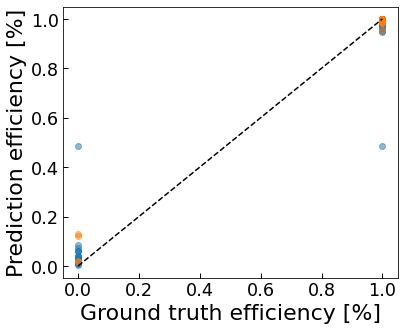

In [11]:
yc_train_pred = yc_train_pred_mean
yc_test_pred = yc_test_pred_mean
yc_pred = yc_pred_mean

from sklearn.metrics import mean_squared_error
mse = mean_squared_error
mse_train = mse(yc_train_pred,yc_train)
mse_test = mse(yc_test_pred,yc_test)
mse_all = mse(yc_pred, yc)
print ('train rmse: %.4f' % (np.sqrt(mse_train)))
print ('test rmse: %.4f' % (np.sqrt(mse_test)))
print ('all rmse: %.4f' % (np.sqrt(mse_all)))


rsquared_train = r2_score(yc_train,yc_train_pred)
rsquared_test = r2_score(yc_test, yc_test_pred)
rsquared_all = r2_score(yc, yc_pred)
print ('train R^2: %.4f' % (rsquared_train))
print ('test R^2: %.4f' % (rsquared_test))
print ('all R^2: %.4f' % (rsquared_all))

sprman_train = spearmanr(yc_train_pred, yc_train)
sprman_test = spearmanr(yc_test_pred,yc_test)
sprman_all = spearmanr(yc_pred,yc)
print ('train spearman: %.4f' % (sprman_train[0]))
print ('test spearman: %.4f' % (sprman_test[0]))
print ('all spearman: %.4f' % (sprman_all[0]))

fs = 22
plt.figure(figsize=(6, 5))
plt.scatter(yc_train,yc_train_pred, alpha =0.5)
plt.scatter(yc_test,yc_test_pred, alpha =0.5)
#plt.scatter(y_scaled,y_pred, alpha =0.5)
ycref = np.arange(0, 1.1, 0.1)
plt.plot(ycref, ycref, '--',color='black')
plt.xlabel('Ground truth efficiency [%]', fontsize = fs)
plt.ylabel('Prediction efficiency [%]', fontsize = fs)
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
#plt.title("Gradient Boosting")
plt.tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
#plt.savefig("Pervoskite Opt for Scale-up/Prelim_data_analysis/data_plots/RFR"+str(X1.name[:4])+".png",dpi=300)
plt.show()

### Load the previous experimental data

In [19]:
df_previous  = pd.read_excel("./new_plamsa_previous_selected_20200927.xlsx", sheet_name= "Sheet1")
df_previous.iloc[:,2] = df_previous.iloc[:,2] /10
df_previous.iloc[:,3] = df_previous.iloc[:,3] /1000
df_previous = df_previous.iloc[:,:11]
print(df_previous.columns)
df_previous.columns = ['', 'Temperature [\N{DEGREE SIGN}C]', 'Speed [cm/s]',
       'Spray Flow [mL/min]', 'Plamsa Height [cm]', 'Plasma Gas Flow [L/min]', 'Plasma DC [%]',
        'Jsc [mA/cm2]', 'Voc [V]', 'FF [-]', 'Efficiency [%]']
df_previous = df_previous.sort_values(by=list(df_previous.iloc[:,[1,2,3,4,5,6,-1]].columns), ignore_index = True)
# df_previous = df_previous.drop_duplicates(['Temperature [\N{DEGREE SIGN}C]', 'Speed [mm/s]',
#        'Spray Flow [uL/min]', 'Plamsa Height [cm]', 'Plasma Gas Flow [L/min]', 'Plasma DC [%]'], keep = 'last', ignore_index = True)
df_previous = df_previous.iloc[:,1:]
df_previous

Index(['Unnamed: 0', 'Temp [degC]', 'speed [mm/s]', 'sprayFL [uL/min]',
       'plamsaH [cm]', 'gasFL [L/min]', 'plasmaDC [%]', 'Jsc [mA/cm2]',
       'Voc [V]', 'FF [-]', 'Efficiency [%]'],
      dtype='object')


,Temperature [°C],Speed [cm/s],Spray Flow [mL/min],Plamsa Height [cm],Plasma Gas Flow [L/min],Plasma DC [%],Jsc [mA/cm2],Voc [V],FF [-],Efficiency [%]
0,125,10.0,2.5,1.5,15,100,0.763209,16.678352,0.561663,7.1494
1,125,10.0,2.5,1.5,15,100,0.764307,16.693951,0.594879,7.5902
2,125,15.0,3.0,1.0,15,100,0.777895,22.145733,0.589384,10.1534
3,125,15.0,3.0,1.0,15,100,0.933930,21.041220,0.661820,13.0054
4,135,10.0,2.5,1.0,15,100,0.780622,18.418326,0.593654,8.5354
...,...,...,...,...,...,...,...,...,...,...
61,145,20.0,5.0,1.0,15,100,0.966357,19.217004,0.682210,12.6690
62,145,20.0,5.0,1.0,15,100,0.957637,19.597432,0.728667,13.6751
63,150,10.0,3.5,1.0,15,100,0.966984,19.472074,0.628517,11.8345
64,150,10.0,3.5,1.0,15,100,0.937632,20.745524,0.676690,13.1627


In [12]:
## Total process conditions: 11x9x7x5x4x3 = 41580 conditions

temp_min, temp_max, temp_step = [125, 175, 5] ## Unit: degC ## 11 steps
temp_var = np.arange(temp_min, temp_max+temp_step, temp_step)
temp_num = len(temp_var)

speed_min, speed_max, speed_step = [100, 300, 25] ## Unit: mm/s ## 9 steps
speed_var = np.arange(speed_min, speed_max+speed_step, speed_step)
speed_num = len(speed_var)

sprayFL_min, sprayFL_max, sprayFL_step = [2000, 5000, 500] ## Unit: uL/min ## 7 steps
sprayFL_var = np.arange(sprayFL_min, sprayFL_max+sprayFL_step, sprayFL_step) 
sprayFL_num = len(sprayFL_var)

gasFL_min, gasFL_max, gasFL_step = [15, 35, 5] ## Unit: L/min ## 5 steps
gasFL_var = np.arange(gasFL_min, gasFL_max+gasFL_step, gasFL_step)
gasFL_num = len(gasFL_var)

plasmaDC_min, plasmaDC_max, plasmaDC_step = [25, 100, 25] # Unit: [%] ## 4 steps
plasmaDC_var = np.arange(plasmaDC_min, plasmaDC_max+plasmaDC_step, plasmaDC_step)
plasmaDC_num = len(plasmaDC_var)

plasmaH_min, plasmaH_max, plasmaH_step = [0.8, 1.2, 0.2] # Unit: cm ## 3 steps
plasmaH_var = np.arange(plasmaH_min, plasmaH_max+plasmaH_step, plasmaH_step)
plasmaH_num = len(plasmaH_var)


var_array = [temp_var, speed_var, 
             sprayFL_var, plasmaH_var, 
             gasFL_var, plasmaDC_var]
x_labels = ['Temperature [\N{DEGREE SIGN}C]', 
            'Speed [mm/s]',
            'Spray Flow [uL/min]', 
            'Plamsa Height [cm]', 
            'Plasma Gas Flow [L/min]', 
            'Plasma DC [%]']

In [13]:
def x_normalizer(X):
    
    def max_min_scaler(x, x_max, x_min):
        return (x-x_min)/(x_max-x_min)
    
    x_norm = []
    for x in (X):
           x_norm.append([max_min_scaler(x[i], 
                                         max(var_array[i]), 
                                         min(var_array[i])) for i in range(len(x))])  
    return np.array(x_norm)

def x_denormalizer(x_norm):
    def max_min_rescaler(x, x_max, x_min):
        return x*(x_max-x_min)+x_min
    
    x_original = []
    for x in (x_norm):
           x_original.append([max_min_rescaler(x[i], 
                                         max(var_array[i]), 
                                         min(var_array[i])) for i in range(len(x))])
    return np.array(x_original)



def get_closest_array(suggested_x):
    
    def get_closest_value(given_value, array_list):
        absolute_difference_function = lambda list_value : abs(list_value - given_value)
        closest_value = min(array_list, key=absolute_difference_function)
        return closest_value
    
    var_list = var_array
    modified_array = []
    for x in suggested_x:
        modified_array.append([get_closest_value(x[i], var_list[i]) for i in range(len(x))])
    return np.array(modified_array)

In [16]:
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs.random_design import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign

parameter_space = ParameterSpace([ContinuousParameter('temp', 0-1/(temp_num-1)/2, 1+1/(temp_num-1)/2),
                                 ContinuousParameter('speed', 0-1/(speed_num-1)/2, 1+1/(speed_num-1)/2),
                                 ContinuousParameter('sprayFL', 0-1/(sprayFL_num-1)/2, 1+1/(sprayFL_num-1)/2),
                                 ContinuousParameter('plamsaH', 0-1/(plasmaH_num-1)/2, 1+1/(plasmaH_num-1)/2),
                                 ContinuousParameter('gasFL', 0-1/(gasFL_num-1)/2, 1+1/(gasFL_num-1)/2),
                                 ContinuousParameter('plasmaDC', 0-1/(plasmaDC_num-1)/2, 1+1/(plasmaDC_num-1)/2)
                                 ])


In [23]:
df_thiswork  = pd.read_excel("./Experimental Data/All_device_data_processed_20210126.xlsx", sheet_name= "Sheet1")
df_thiswork = df_thiswork.iloc[:99,0:13]
thiswork_device = df_thiswork['Film Success or not?'] == 'Yes'
df_thiswork[thiswork_device].iloc[:,2:-1]

,Temperature [°C],Speed [mm/s],Spray Flow [uL/min],Plamsa Height [cm],Plasma Gas Flow [L/min],Plasma DC [%],Jsc [mA/cm2],Voc [V],FF [-],Efficiency [%]
0,155,200,5000,1.2,35,50,16.2619,0.932514,0.39,5.914137
2,135,200,2500,1.0,25,75,23.1761,0.926920,0.60,12.889485
6,140,150,4000,1.0,20,75,19.9090,1.023000,0.69,14.053536
8,130,175,3500,0.8,25,75,21.8800,1.044000,0.74,16.904349
9,135,125,2500,1.2,20,25,22.0476,1.025000,0.71,16.045155
...,...,...,...,...,...,...,...,...,...,...
94,140,150,3500,1.2,20,50,19.7860,1.021000,0.79,15.959000
95,140,150,3500,1.0,20,50,18.9330,0.978000,0.58,10.739000
96,145,125,3000,1.2,16,50,22.7520,0.987000,0.74,16.621000
97,150,175,3500,1.0,16,50,26.4330,0.978000,0.58,14.988000


In [35]:
def f_obj(x):
    y_hat_list = []
    for i in np.arange(len(GBregressor_list)):
        y_hat = GBregressor_list[i].predict(scaler.transform(x))
        y_hat_list.append(y_hat)
    y_hat_mean = np.mean(y_hat_list, axis = 0)
    y_pred = scaler_y.inverse_transform(y_hat_mean)
    return y_pred

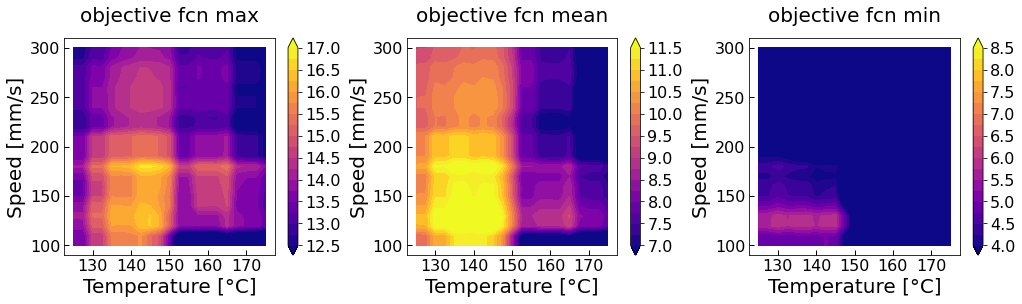

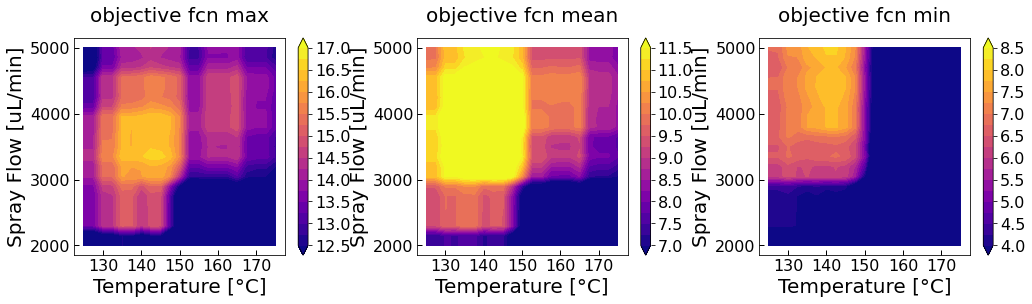

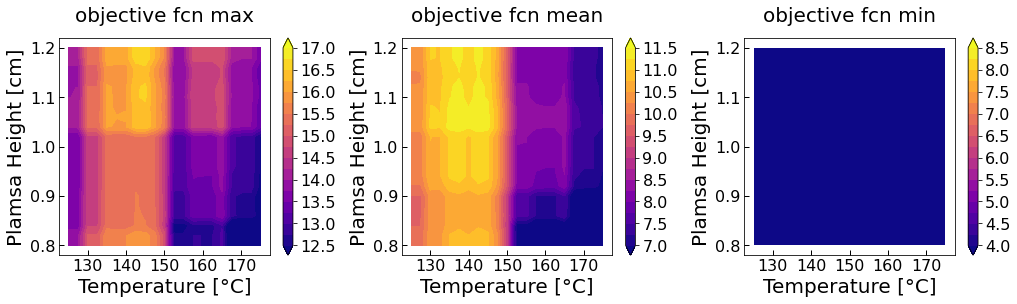

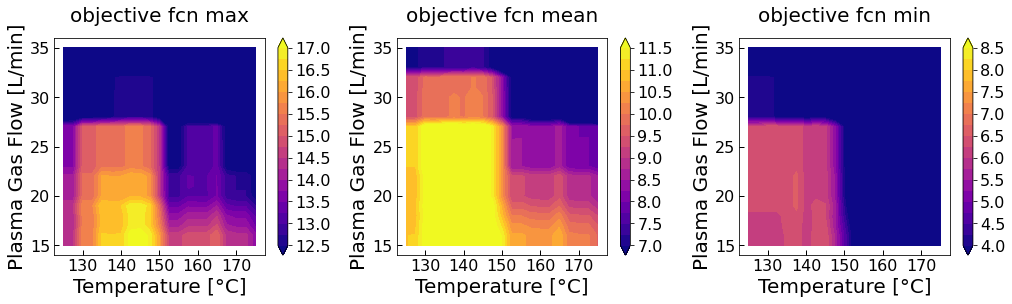

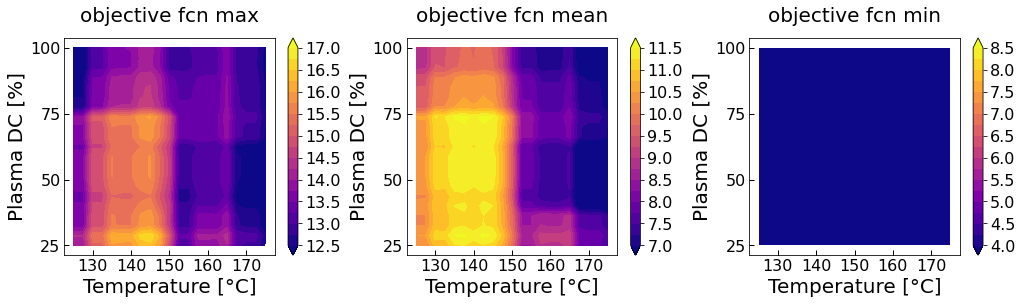

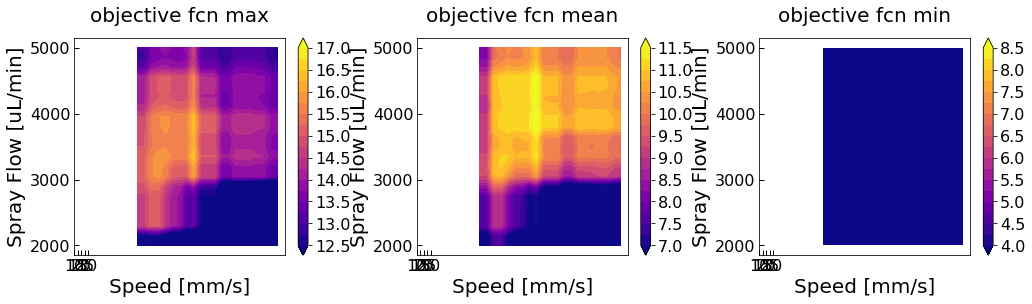

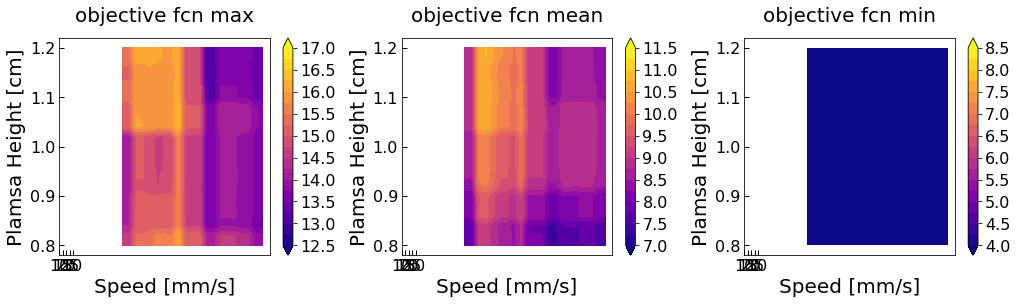

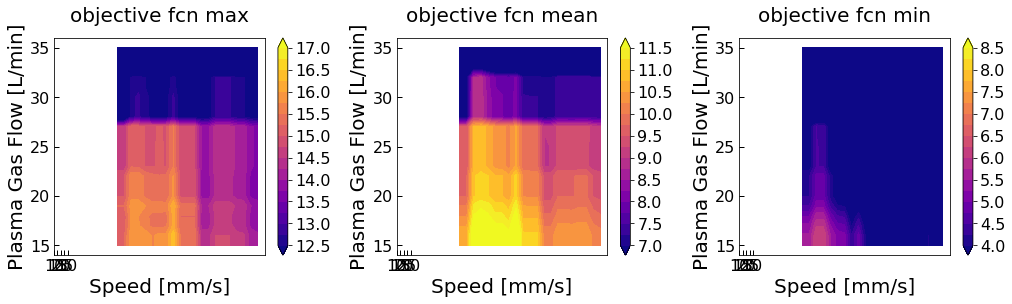

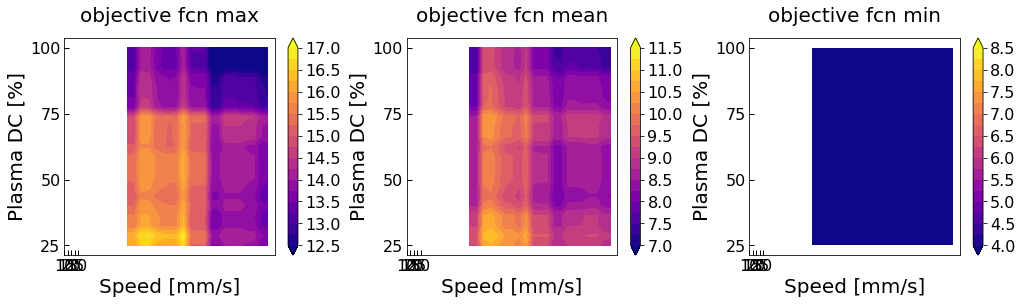

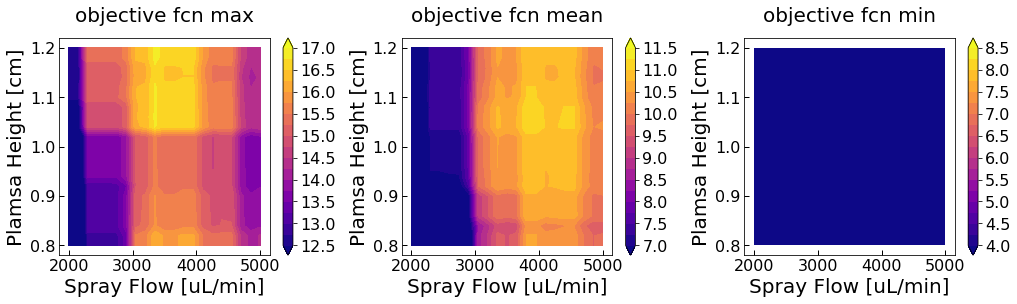

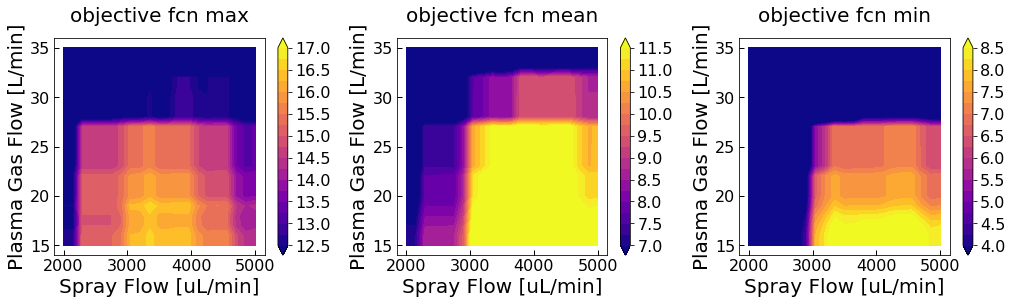

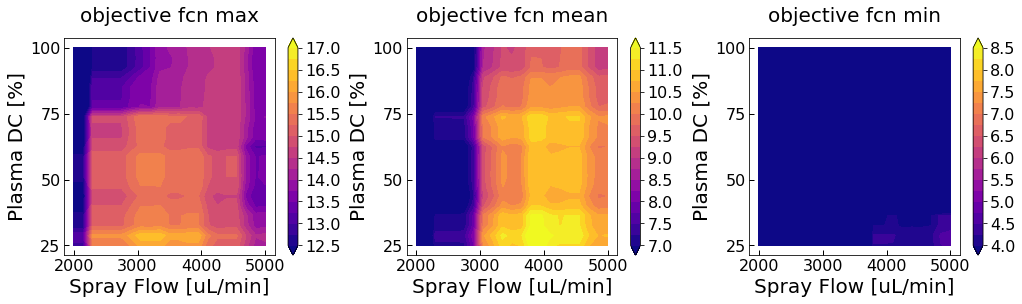

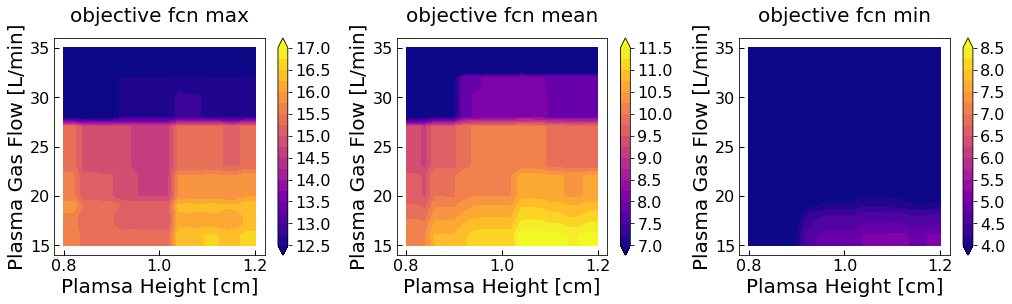

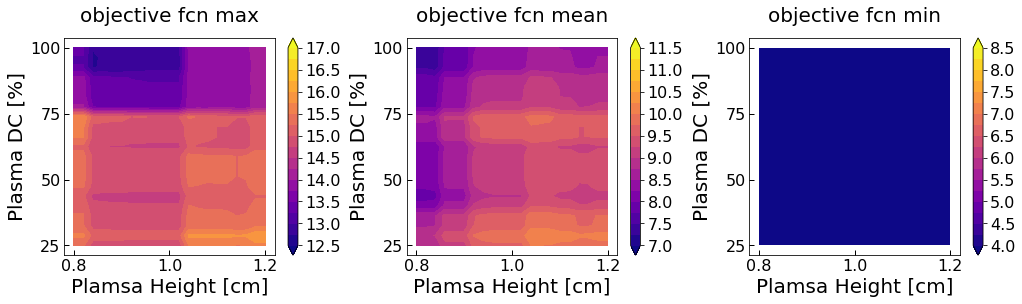

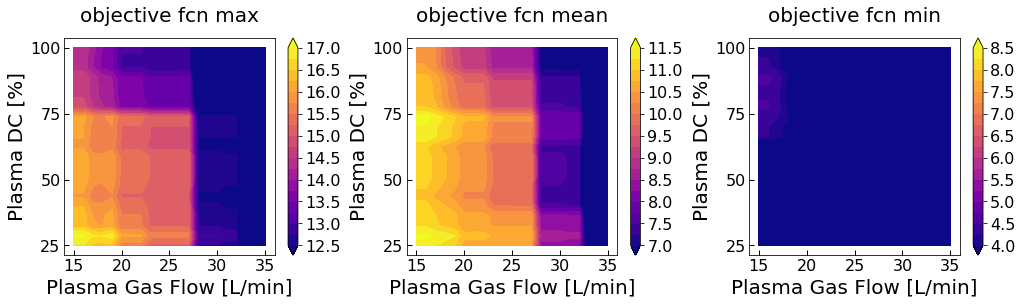

In [48]:
design = RandomDesign(parameter_space)
x_sampled = design.get_samples(200)
x_columns = df_thiswork.iloc[:,2:8].columns
input_dim = len(x_columns)
for i in range(input_dim):
    for j in range(input_dim-i-1):      
## Generate a 2D grid for Contour plot
        ind1 = i
        ind2 = j+i+1
        n_steps =21
        x1x2y_pred, x1x2y_uncer =[[],[]]
        for x1 in np.linspace(0, 1, n_steps):
            for x2 in np.linspace(0, 1, n_steps):
                x_temp = np.copy(x_sampled)
                x_temp[:,ind1] = x1
                x_temp[:,ind2] = x2
                y_pred = f_obj(x_denormalizer(x_temp))
                x1_org = x_denormalizer(x_temp)[0,ind1]
                x2_org = x_denormalizer(x_temp)[0,ind2]
                x1x2y_pred.append([x1_org, x2_org, np.max(y_pred), np.mean(y_pred), np.min(y_pred)])                
        x1 = np.array(x1x2y_pred, dtype=object)[:,0].reshape(n_steps, n_steps)
        x2 = np.array(x1x2y_pred, dtype=object)[:,1].reshape(n_steps, n_steps)
        y_pred_max = np.array(x1x2y_pred, dtype=object)[:,2].reshape(n_steps, n_steps)
        y_pred_mean = np.array(x1x2y_pred, dtype=object)[:,3].reshape(n_steps, n_steps)
        y_pred_min = np.array(x1x2y_pred, dtype=object)[:,4].reshape(n_steps, n_steps)
        
        fs = 20
        title_pad = 16
        
## Contour for Prediction Efficiency Mean
        fig,axes = plt.subplots(1, 3, figsize=(17, 4), sharey = False, sharex = False)
        colorbar_offset = [12.5, 7, 4]
        for ax, c_offset, y in zip(axes, colorbar_offset,
                                   [y_pred_max, y_pred_mean, y_pred_min]):
            
            c_plt1 = ax.contourf(x1, x2, y, levels = np.arange(19)*0.25+c_offset, cmap='plasma', extend = 'both')
            cbar = fig.colorbar(c_plt1, ax= ax)
            cbar.ax.tick_params(labelsize=fs*0.8)
#             ax.scatter(x_denormalizer(X)[:, ind1], 
#                        x_denormalizer(X)[:, ind2], 
#                        s = 55, facecolors='none', alpha = 0.9, edgecolor = 'green')
#             ax.scatter(x_denormalizer(Xc[Yc[:,-1]==0])[:, ind1], ## show the conditions with poor film quality
#                        x_denormalizer(Xc[Yc[:,-1]==0])[:, ind2], 
#                        s = 55, facecolors='none', alpha = 0.9, edgecolor = 'red')
            ax.set_xlabel(str(x_columns[ind1]),fontsize =  fs)
            ax.set_ylabel(str(x_columns[ind2]),fontsize =  fs)

            x1_delta = (np.max(x1)-np.min(x1))*0.05
            x2_delta = (np.max(x2)-np.min(x2))*0.05
            ax.set_xlim(np.min(x1)-x1_delta, np.max(x1)+x1_delta)
            ax.set_ylim(np.min(x2)-x2_delta, np.max(x2)+x2_delta)
            ax.tick_params(direction='in', length=5, width=1, labelsize = fs*.8)#, grid_alpha = 0.5
            if ind1==0:#Temp
                ax.set_xticks([130, 140, 150, 160, 170])
            if ind1==1:#Speed
                ax.set_xticks([10, 15, 20, 25, 30])
            if ind1==4:#PlasmaGasFL
                ax.set_xticks([15, 20, 25, 30, 35])
            if ind2==5:#PlasmaDC
                ax.set_yticks([25, 50, 75, 100])
            #ax.grid(True, linestyle='-.')

        axes[0].set_title('objective fcn max', pad = title_pad,fontsize =  fs)
        axes[1].set_title('objective fcn mean', pad = title_pad,fontsize =  fs)
        axes[2].set_title('objective fcn min', pad = title_pad,fontsize =  fs)

        plt.subplots_adjust(wspace = 0.3)
        plt.show()
